In [210]:
%reload_ext autoreload

In [211]:
# Packages needed

#!pip install "tabulate" "pandas_summary" "imblearn" "joblib"
#!pip install fastai==0.7.0
#!pip install eli5
#!pip install ggplot
#!pip install pdp

In [212]:
# Imports

%load_ext autoreload
%autoreload 2

%matplotlib inline
import sys
from pandas import Timestamp
import pandas as pd
from fastai.imports import *
from fastai.structured import *
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.externals import joblib
from sklearn.model_selection import GridSearchCV

#import numpy as np
#import random
#from matplotlib import pyplot
#from pandas_summary import DataFrameSummary
#from IPython.display import display
#from tabulate import tabulate
#from sklearn.model_selection import GridSearchCV
#from scipy.stats.mstats import mode, gmean, hmean
#from sklearn import metrics

#set_plot_sizes(12,14,16)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [213]:
sys.path.append('../lib')
import utils
import preprocessing

In [214]:
# Load in data

PATH = "../data/"
df_raw = pd.read_csv(f'{PATH}churn.csv', low_memory=False, 
                     parse_dates=['canceldate', 'licence_registration_date', 'golive_date'])

In [215]:
print(len(df_raw), df_raw.shape)
print(len(df_raw.loc[df_raw.licence_status != "STAGING"]), df_raw.loc[df_raw.licence_status != "STAGING"].shape)

df_processed = preprocessing.prepare_data(df_raw.loc[df_raw.licence_status != "STAGING"])

print(len(df_processed), df_processed.shape)

5889 (5889, 38)
5547 (5547, 38)
Sorting dataframe by licence_registration_date ...
Converting annual_revenue to a number ...
Defaulting all NaN values with median ...
Defaulting annual_revenue for missing values to the plans mean or platform medeian ...
Binning last_login_days
day          4636
month+        545
few_days       99
fortnight      96
week           88
month          83
Name: last_login_categories, dtype: int64
Binning NPS data
Fixing days_active abnormal values ...
One-hot encoding customer_account_status
One-hot encoding plan
One-hot encoding nps
Preprocessing dates ...
Dropping features ...
Replacing NaN values with median and adding '_was_nan' column ...
Convert categorical features into numbers ...
List any features that still have NaN values ...
5547 (5547, 141)


In [216]:
df_filtered = df_processed

In [217]:
df_trn, y_trn, nas = proc_df(df_filtered, 'churned')
print(len(df_trn), df_trn.shape)

5547 (5547, 140)


In [218]:
def split_vals(a,n): return a[:n], a[n:]

n_valid = 500
n_trn = len(df_trn)-n_valid
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)

In [219]:
X_train.shape, y_train.shape

((5047, 140), (5047,))

In [220]:
# Fix the dataset imbalance

sm = SMOTE(random_state=12, ratio = 1.0)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)

In [221]:
X_train_res.shape, y_train_res.shape

((5916, 140), (5916,))

In [222]:
# Show any features with NaN values
preprocessing.features_with_nan(df_filtered)

In [223]:
X_train.shape, y_train.shape

((5047, 140), (5047,))

In [224]:
m = RandomForestClassifier(
    n_estimators=2000,
    min_samples_leaf=3, 
    max_features='sqrt',
    n_jobs=-1,
    max_depth=3,
    bootstrap=False,
    criterion='entropy',
    class_weight={0: 3, 1: 1}
    )

m.fit(X_train_res, y_train_res)
#m.fit(X_train, y_train)

y_pred = m.predict(X_valid)
print(utils.uber_score(y_valid, y_pred))
utils.conf_matrix(y_valid, y_pred)

# Save to file in the current working directory
joblib_file = "churn_model.pkl"
joblib.dump(m, joblib_file)

0.7555555555555555 0.6754966887417219 0.7132867132867133 0.836 0.5989435586422772 0.164
None
tp, fn, fp, tn
[[316  33]
 [ 49 102]]


['churn_model.pkl']

In [225]:
#df_filtered.plot('golive_days', 'days_active', 'scatter', alpha=0.01, figsize=(10,8));

CPU times: user 26.7 s, sys: 4.37 s, total: 31.1 s
Wall time: 25.9 s


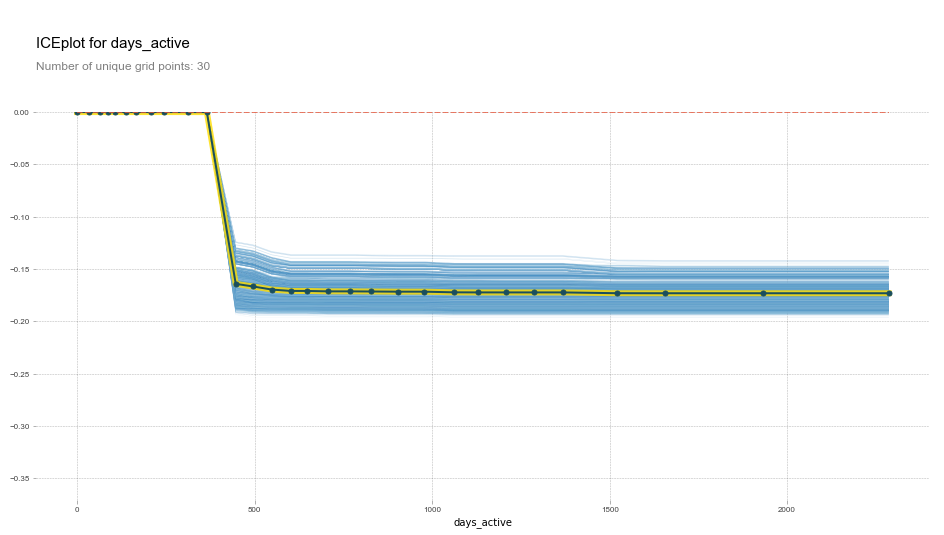

In [232]:
from pdpbox import pdp

x = get_sample(X_train, 2000)

def plot_pdp(feat, clusters=None, feat_name=None):
    feat_name = feat_name or feat
    p = pdp.pdp_isolate(m, x, feat, 30)
    return pdp.pdp_plot(p, feat_name, plot_lines=True,
                        cluster=clusters is not None,
                        n_cluster_centers=clusters)

%time plot_pdp('days_active')

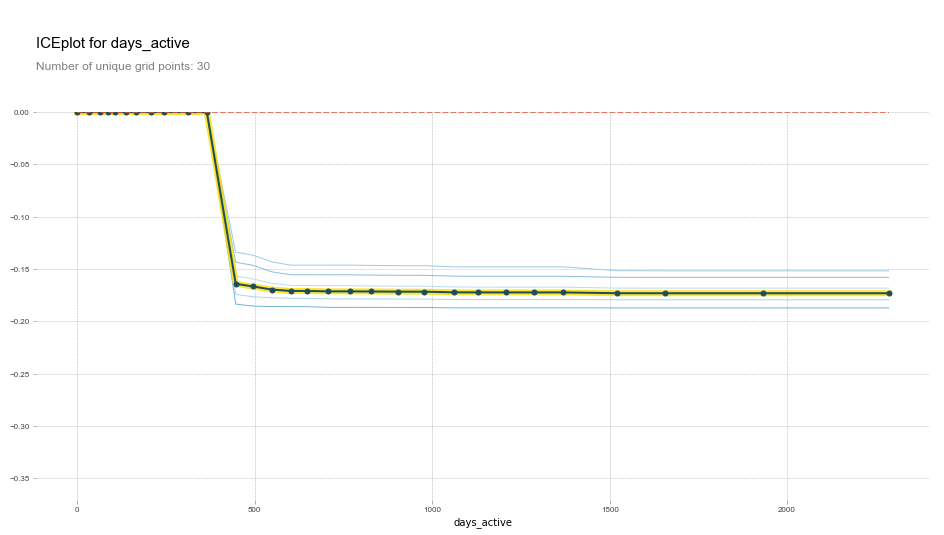

In [233]:
plot_pdp('days_active', clusters=5)

In [228]:
fi = rf_feat_importance(m, X_valid); fi[:10]

,cols,imp
1,days_active,0.160723
6,cases_total,0.083304
8,cases_closed,0.080276
11,annual_revenue,0.076806
7,cases_open,0.075503
9,cases_age_hours_total,0.070046
59,plan_PLAN-S-19Q1,0.054135
65,plan_STANDARD,0.029716
57,plan_PLAN-S,0.028137
5,golive_days,0.027125


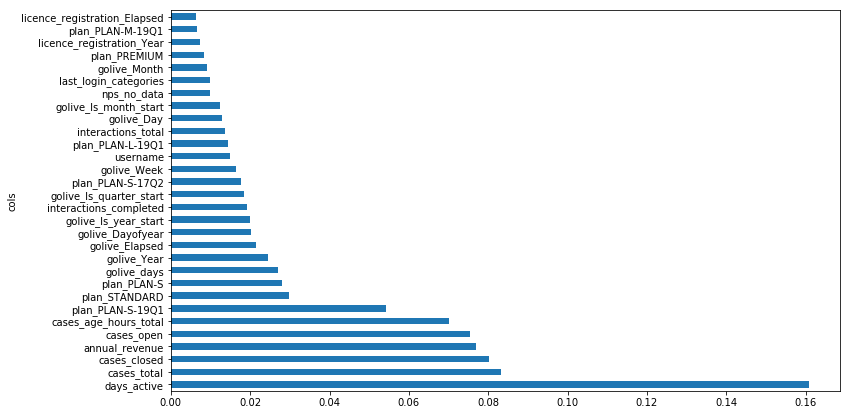

In [229]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)
plot_fi(fi[:30]);

In [203]:
to_keep = fi[fi.imp>0.01].cols; len(to_keep)
df_keep = df_trn[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)

In [204]:
m = RandomForestClassifier(
    n_estimators=2000,
    min_samples_leaf=3, 
    max_features='sqrt',
    n_jobs=-1, 
    max_depth=3,
    bootstrap=False,
    criterion='entropy',
    class_weight={0: 4, 1: 1}
    )

m.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, class_weight={0: 4, 1: 1},
                       criterion='entropy', max_depth=3, max_features='sqrt',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=3,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=2000, n_jobs=-1, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

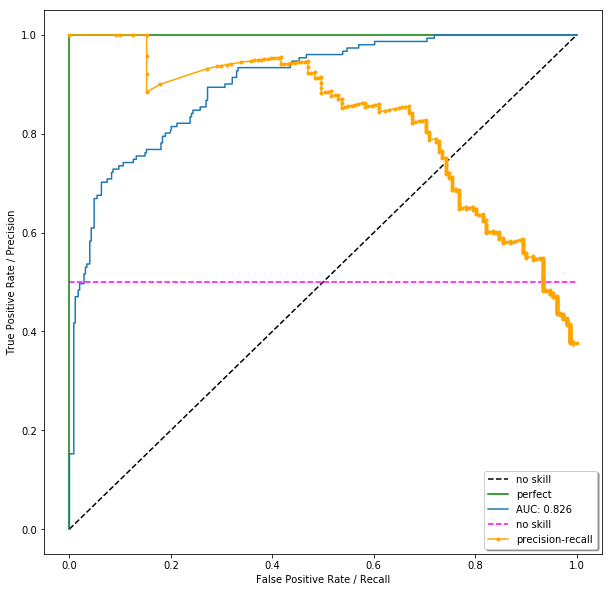

auc=0.826 ap=0.828


In [205]:
utils.plot_roc_pr(m, X_valid, y_valid)

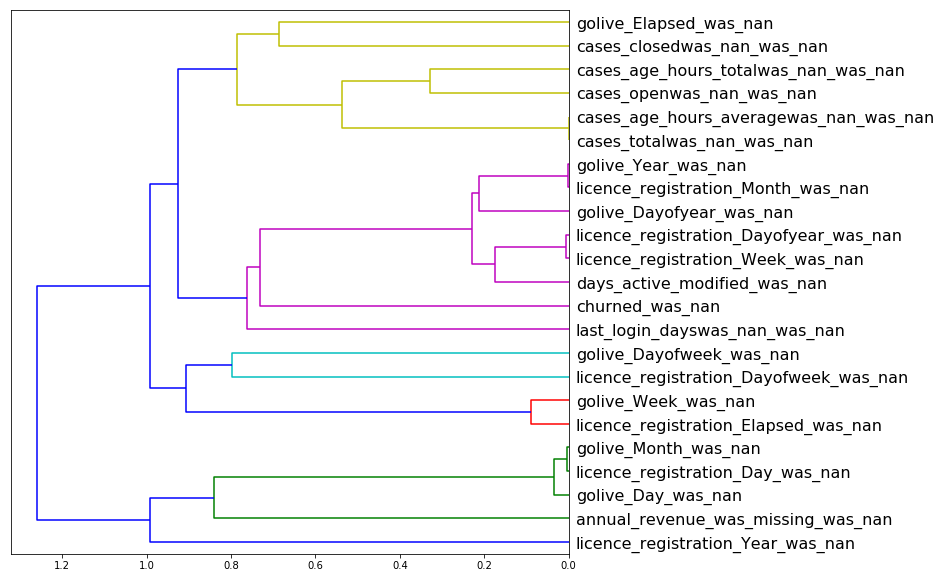

In [208]:
from scipy.cluster import hierarchy as hc

corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(10,10))
dendrogram = hc.dendrogram(z, labels=df_trn.columns, orientation='left', leaf_font_size=16)
plt.show()

In [209]:
print("precision, recall, f1_score, accuracy, cohen_kappa_score, mean abs error")

for column in df_keep.columns:
    m = RandomForestClassifier(
        n_estimators=200,
        min_samples_leaf=2, 
        max_features='sqrt',
        n_jobs=-1, 
        max_depth=3,
        bootstrap=False,
        criterion='entropy',
        class_weight={0: 4, 1: 1}
        )

    x, _ = split_vals(df_keep.drop(columns=[column]), n_trn)
    m.fit(x, y_train)
    y_pred = m.predict(x)
    print(column, utils.uber_score(y_train, y_pred))

precision, recall, f1_score, accuracy, cohen_kappa_score, mean abs error
0.9896995708154507 0.7795807978363759 0.8721633888048411 0.8660590449772142 0.735608778995085 0.1339409550227858
days_active None
0.9968253968253968 0.7430696416497633 0.8514429595196591 0.84802853180107 0.702521755174738 0.15197146819893007
cases_closed None
0.997649271274095 0.7173766058147397 0.8346116027531957 0.8333663562512383 0.6755113253815958 0.16663364374876163
cases_total None
0.997649271274095 0.7173766058147397 0.8346116027531957 0.8333663562512383 0.6755113253815958 0.16663364374876163
annual_revenue None
0.9967166979362101 0.7183908045977011 0.8349705304518664 0.8335644937586685 0.675789469176262 0.1664355062413315
cases_age_hours_total None
0.9950383400992332 0.7457741717376606 0.8525603864734299 0.8488210818307905 0.7038358069819595 0.15117891816920942
cases_open None
0.9957845433255269 0.7187288708586883 0.8348713921068133 0.8333663562512383 0.6753387771842287 0.16663364374876163
plan_PLAN-S-19Q1